Max hop count is : 5.0
amount of pairs with shortest path = 1 : 3250.0
amount of pairs with shortest path = 2 : 8052.0
amount of pairs with shortest path = 3 : 2327.0
amount of pairs with shortest path = 4 : 225.0
amount of pairs with shortest path = 5 : 7.0


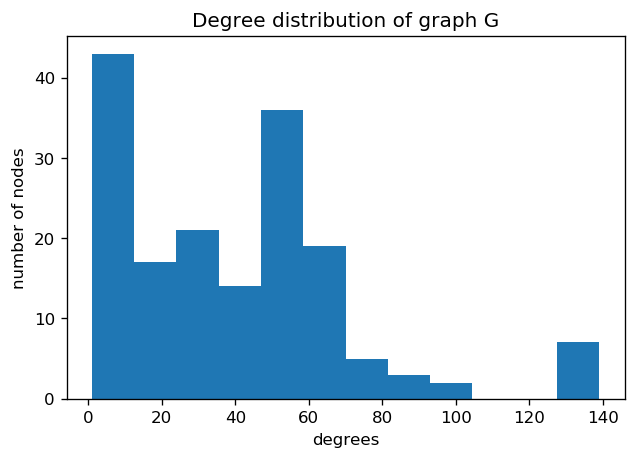

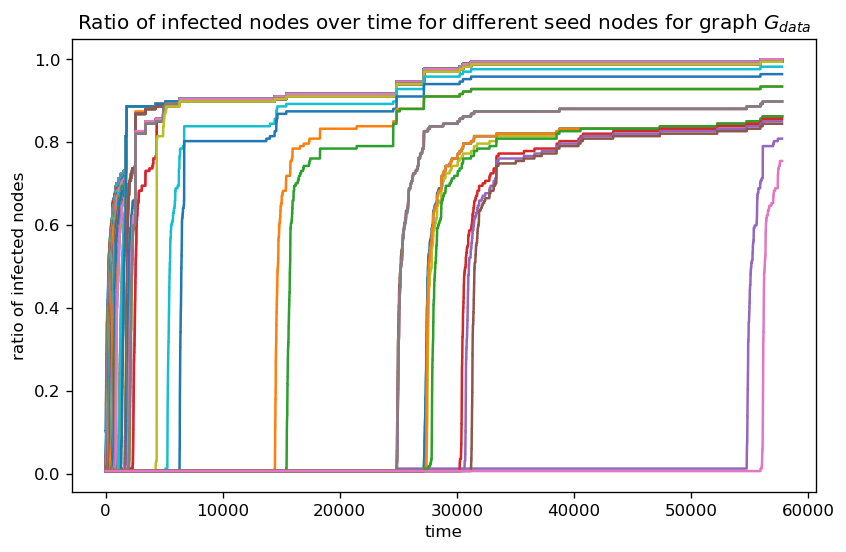

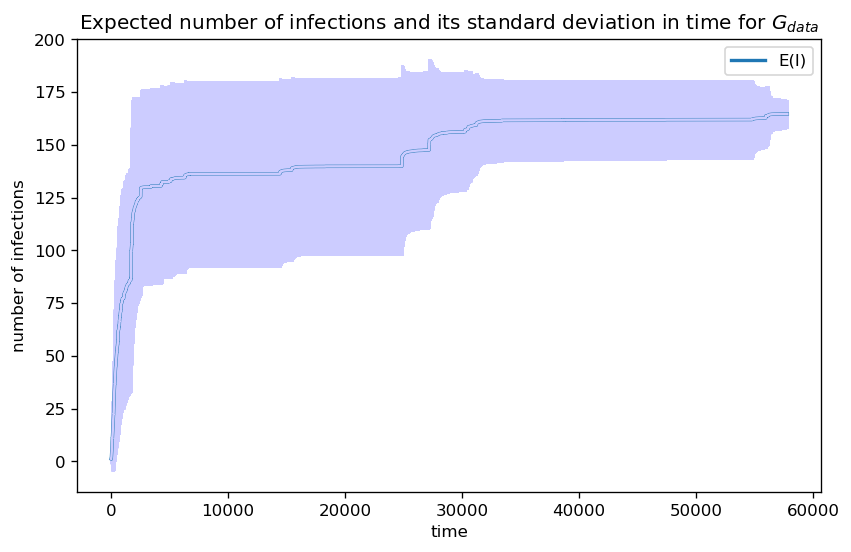

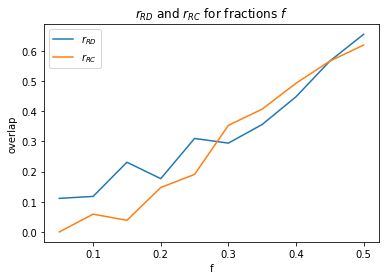

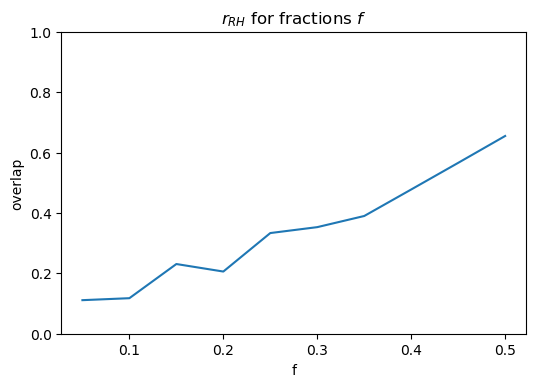

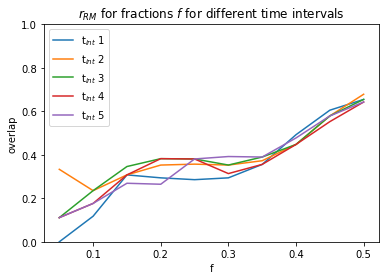

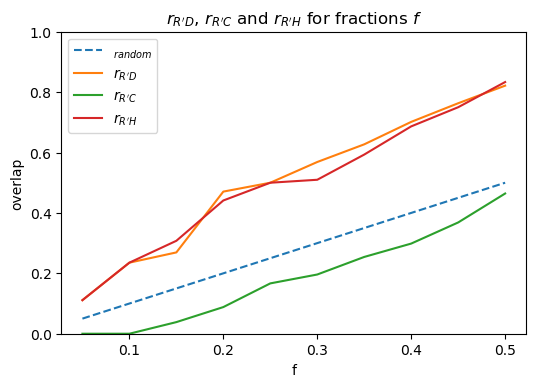

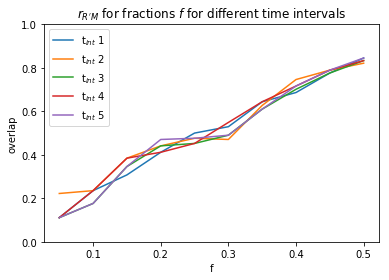

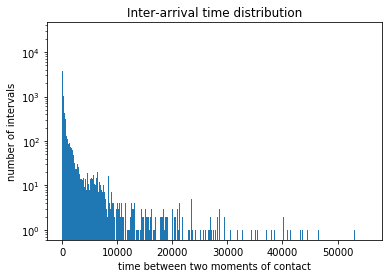

In [8]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rand
import math
import time

# Load dataset and organize it
start_time = time.time()
emails = pd.read_csv('manufacturing_emails_temporal_network.csv', sep=';', engine='python')
dataset = emails[['node1', 'node2', 'timestamp']].round(0).astype(int)
node1users = pd.unique(dataset.node1)
node2users = pd.unique(dataset.node2)
users = np.unique(np.append(node1users, node2users))
n_users = len(users)

node_1 = np.transpose(dataset.node1.values)
node_2 = np.transpose(dataset.node2.values)
timestamp = np.transpose(dataset.timestamp.values)

# Define all graphs to be studied

OG_data = np.column_stack((node_1, node_2, timestamp))

rand.seed(42)
random_index = rand.sample(range(len(OG_data[:, 0])), len(OG_data[:, 0]))
timestamp_shuffle = [OG_data[i, 2] for i in random_index]

G_2 = np.column_stack((node_1, node_2, timestamp_shuffle))
G_2 = G_2[G_2[:, 2].argsort()]

G_3 = np.zeros([3, len(OG_data[:, 0])]).round(0).astype(int)
G_3 = np.transpose(G_3)
G_3_links = np.sort(dataset.values[:, 0:2], axis=1)
G_3_links = np.unique(G_3_links, axis=0)

for i in range(len(timestamp)):
    G_3[i] = np.append(G_3_links[rand.randint(0, len(G_3_links) - 1)], timestamp[i])


# Define network and produce all things things asked in assigment

def investigate_everything_of(G_data, G_name):

    def topology(network):
        def_A = np.zeros((n_users, n_users))
        for i in users:
            links_node_1 = network[np.where(network[:, 0] == i), 1]
            links_node_2 = network[np.where(network[:, 1] == i), 0]
            adjUser = np.unique(np.append(links_node_1, links_node_2))
            def_A[i - 1, adjUser - 1] += 1

        def_n_links = np.sum(def_A) / 2
        def_degrees = np.sum(def_A, axis=0)
        def_n_pairs = n_users * (n_users - 1) / 2
        dens_links = def_n_links / def_n_pairs

        def_E_d = def_n_links / n_users
        def_var_d = np.var(def_degrees)

        return def_A, def_n_links, def_degrees, def_n_pairs, def_E_d, def_var_d


    # ASSIGNMENT 1: Network topology: define network
    A, n_links, degrees, n_pairs, E_d, var_d = topology(G_data)


    # ASSIGNMENT 2: plot the degree distribution
    def make_hist(degrees, graph_name = 'G'):
        plt.figure(dpi=120)
        plt.title("Degree distribution of graph " + graph_name)
        plt.xlabel("degrees")
        plt.ylabel("number of nodes")
        plt.hist(degrees, bins=12)


    make_hist(degrees)

    # ASSIGNMENT 3: Network assortivity is given by: rho_d = ((N_1)*(N_3) - (N_2)^2)/((N_1)*(sum(j) d(j)^3) - (N_2)^2)
    def assortivity(degrees):
        N_1 = 2 * n_links
        N_2 = np.dot(degrees, degrees)
        N_3 = np.dot(degrees, np.dot(A, degrees))
        rho_d = (N_1 * N_3 - N_2 ** 2) / (N_1 * np.sum(degrees ** 3) - N_2 ** 2)

        return rho_d


    # ASSIGNMENT 4: Clustering coefficient
    def cluster_coeff(degrees):
        c_c_i = np.zeros((n_users))
        for i in users:
            if degrees[i - 1] == 1:
                # c = 0 if d_i = 1. continue lets the loop go to the following iteration in users.
                c_c_i[i - 1] = 0
                continue
            c_neighbours = A[:, i - 1] == 1
            c_neighbours = c_neighbours * users
            c_neighbours = c_neighbours[c_neighbours != 0]
            linksBetweenNeighbours = 0
            for k in c_neighbours:
                linksBetweenNeighbours = linksBetweenNeighbours + np.dot(A[:, i - 1], A[:, k - 1])
            c_c_i[i - 1] = 2 * (linksBetweenNeighbours / 2) / (degrees[i - 1] * (degrees[i - 1] - 1))
        c_C = np.sum(c_c_i) / n_users
        return c_c_i, c_C


    # ASSIGNMENT 5: Average hopcount and diameter
    def hop_count():
        min_hops = np.zeros((n_users, n_users))
        min_hops += A
        max_closeness = 1
        # Here we assume the whole matrix to be connected
        # Loop that works very difficultly, will explain how it works some other time but it works. Telling it here will be cumbersome
        while (np.sum(min_hops == 0)) > n_users > max_closeness:
            for i in users[:-1]:
                j = 0
                while j < i:
                    if min_hops[i, j] != 0:
                        j += 1
                        continue
                    for cns1, cns2 in zip(np.linspace(1, max_closeness, max_closeness),
                                          np.flip(np.linspace(1, max_closeness, max_closeness), axis=0)):
                        closest_neighbours = min_hops[i, :] == cns1
                        n_neighbours = closest_neighbours * users
                        n_neighbours = n_neighbours[n_neighbours != 0]  # Removes all zeros from array
                        for k in n_neighbours:
                            if min_hops[k - 1, j] == cns2:
                                min_hops[i, j] = cns1 + cns2
                                min_hops[j, i] = cns1 + cns2
                                break
                    j += 1
            max_closeness += 1

        H_max = np.amax(min_hops)
        avg_hops = np.average(min_hops, axis=1)
        #print("Average hop count is : " + str(avg_hops))
        print("Max hop count is : " + str(H_max))
        print("amount of pairs with shortest path = 1 : " + str(np.count_nonzero(min_hops == 1) / 2))
        print("amount of pairs with shortest path = 2 : " + str(np.count_nonzero(min_hops == 2) / 2))
        print("amount of pairs with shortest path = 3 : " + str(np.count_nonzero(min_hops == 3) / 2))
        print("amount of pairs with shortest path = 4 : " + str(np.count_nonzero(min_hops == 4) / 2))
        print("amount of pairs with shortest path = 5 : " + str(np.count_nonzero(min_hops == 5) / 2))

        return min_hops, H_max, avg_hops


    # ASSIGNMENT 7: Spectral radius
    def spectral_radius():
        eigenvalues = np.linalg.eigvals(A)
        max_eigenvalue = np.amax(eigenvalues)
        print("spectral radius: " + str(abs(round(max_eigenvalue, 2))))


    # ASSIGNMENT 8: Algebraic connectivity
    def algebraic_conn():
        laplacian_matrix = np.diag(degrees) - A
        eigenvalues_laplacian = np.linalg.eigvals(laplacian_matrix)
        eigenvalues_laplacian.sort()
        print("algebraic connectivity: " + str(abs(round(eigenvalues_laplacian[1], 2))))


    # PART B: Simulating temporal network
    def temporal(network):
        seed = users
        timestamp_temporal = network[:, 2]
        end_index = len(network[:, 0])

        infected_n_t = np.ones((np.max(users), np.max(timestamp_temporal)))
        #last_occurence = np.zeros((np.max(users)))

        for i in seed:
            infected = np.zeros((n_users, 2))
            occurence_seed = np.append(np.where(network[:, 0] == i)[0], np.where(network[:, 1] == i)[0])
            if len(occurence_seed):
                t_start = network[occurence_seed[0], 2]
                start_index = np.min(occurence_seed)
                infected[i - 1, 0] = 1
                infected[i - 1, 1] = 0
                timestamp_temporal = network[start_index, 2]
                for t in range(start_index, end_index):
                    timestamp_now = network[t, 2]
                    if timestamp_now != timestamp_temporal:
                        infected_n_t[i - 1, timestamp_temporal - 1] = np.sum(infected[:, 0])
                        timestamp_temporal = timestamp_now
                    if infected[network[t, 0] - 1, 0] == 1 and infected[network[t,0]-1,1] < timestamp_now:
                        if infected[network[t, 1] - 1, 0] == 0:
                            infected[network[t, 1] - 1, 0] = 1
                            infected[network[t, 1] - 1, 1] = network[t, 2]
                    if infected[network[t, 1] - 1, 0] == 1 and infected[network[t,1]-1,1] < timestamp_now:
                        if infected[network[t, 0] - 1, 0] == 0:
                            infected[network[t, 0] - 1, 0] = 1
                            infected[network[t, 0] - 1, 1] = network[t, 2]

                infected_n_t[i - 1, timestamp_temporal - 1] = np.sum(infected[:, 0])
        plt.figure(figsize=(8, 5), dpi=120)
        plt.ylabel("ratio of infected nodes")
        plt.xlabel("time")
        plt.title("Ratio of infected nodes over time for different seed nodes for graph " + G_name)
        for k in users:
            plt.plot(infected_n_t[k - 1, :] / n_users)

        return infected_n_t


    infected_n_t = temporal(G_data)


    # ASSIGNMENT 9: Average number of infected nodes with its error bar
    
    def plot_average_infections(infected_n_t):
        I_E = np.zeros(infected_n_t.shape[1])
        I_std = np.zeros(infected_n_t.shape[1])
        for i in range(len(I_std)):
            I_E[i] = np.average(infected_n_t[:, i][infected_n_t[:, i] > 0])
            I_std[i] = np.std(infected_n_t[:, i][infected_n_t[:, i] > 0])
        plt.figure(figsize=(8, 5), dpi=120)
        plt.errorbar(np.linspace(0, len(I_E), len(I_E)), I_E, I_std, c=[0.8, 0.8, 1])
        plt.plot(I_E, label="E(I)", lw=2)
        plt.xlabel("time")
        plt.ylabel("number of infections")
        plt.legend()
        plt.title("Expected number of infections and its standard deviation in time for " + G_name)


    plot_average_infections(infected_n_t)


    # ASSIGNMENT 10: Ranking vector
    
    treshold = 0.80
    n_tresh = math.ceil(n_users * treshold)
    t_tresh = np.argmin(np.where(infected_n_t >= n_tresh, infected_n_t, np.inf), axis=1)  # if argmin is zero,
                                                                                # all are inf --> treshold not reached
    R = np.argsort(t_tresh[t_tresh > 0]) + 1

    # ASSIGNMENT 11: Overlap degrees and cluster coefficient with ranking vector R

    f_start = 0.05
    f_end = 0.5
    f_step = 0.05
    f_steps = int((f_end - f_start) / f_step) + 1
    fs = np.linspace(f_start, f_end, f_steps)

    def overlap(rank_1, rank_2):
        r_12 = np.zeros(f_steps)
        for i in range(f_steps):
            f = fs[i]
            fN = math.ceil(f * n_users)
            int_12 = np.intersect1d(rank_1[:fN], rank_2[:fN])
            r_12[i] = float(len(int_12)) / fN

        return r_12

    # ASSIGNMENT 12: Other network metrics
    # calculate overlap for R with cluster coefficient (C) and degrees (D)
    c_i, C = cluster_coeff(degrees)

    D_sorted = np.argsort(degrees)[::-1] + 1
    C_sorted = np.argsort(c_i[:])[::-1] + 1

    r_RD = overlap(R, D_sorted)
    r_RC = overlap(R, C_sorted)
    min_hops, H_max, avg_hops = hop_count()
    H_sorted = np.argsort(avg_hops) + 1
    r_RH = overlap(R, H_sorted)
    
    
    # plot overlap for R with cluster coefficient (C) and degrees (D)
    plt.figure(dpi=100)
    plt.plot(fs,fs, '--', label = '$_{random}$')    
    plt.plot(fs, r_RD, label='$r_{RD}$')
    plt.plot(fs, r_RC, label='$r_{RC}$')
    plt.plot(fs, r_RH, label = '$r_{RH}$')
    plt.legend()
    plt.xlabel('f')
    plt.ylabel('overlap')
    plt.title("$r_{RD}$, $r_{RC}$ and $r_{RH}$ for fractions $f$ for " + G_name)
    
    # prepare temporal metric
    n_occurences = np.zeros((n_users))
    maxt = np.max(dataset.timestamp.values)

    # how many contacts each node has
    for i in range(n_users):
        n_occurences[i] = np.sum(np.append(np.where(G_data[:, 0] == i + 1, 1, 0), np.where(G_data[:, 1] == i + 1, 1, 0)))

    # how many contacts each node has per timestep
    occurences = np.zeros((n_users, maxt))
    end_index = len(G_data[:, 0])
    for t in range(end_index):
        i = G_data[t, 0] - 1
        j = G_data[t, 1] - 1
        timestamp_occurence = G_data[t, 2] - 1
        occurences[[i, j], timestamp_occurence] += 1

    # splitting time in n_dt timeintervals
    n_dt = 5
    O_dt = maxt % n_dt
    dt = int(np.floor(maxt / n_dt))

    border_i = 0

    # how high the activity of each node is in each timeinterval
    activities_dt = np.zeros((n_users, n_dt))
    for t_int in range(n_dt):
        border_j = border_i + dt
        if t_int == n_dt - 1:
            border_j += O_dt
        activities_dt[:, t_int] = np.sum(occurences[:, border_i:border_j], axis=1)
        border_i = border_j
    
    
    # overlap between the most (fN) active nodes per timeinterval and R (r_RM)
    def overlap_intime(rank_1):
        r_dt_1M = np.zeros((n_dt, f_steps))
        for t_int in range(n_dt):
            M = np.argsort(activities_dt[:, t_int])[::-1] + 1
            for i in range(f_steps):
                f = fs[i]
                fN = math.ceil(f * n_users)
                int_1M = np.intersect1d(rank_1[:fN], M[:fN])
                r_dt_1M[t_int, i] = float(len(int_1M)) / fN

            plt.plot(fs, r_dt_1M[t_int, :], label="t$_{int  " + str(t_int + 1) + "}$")
        return
    
    # plot temporal metric r_RM
    plt.figure(dpi=100)
    plt.plot(fs,fs, '--', label = '$_{random}$')
    overlap_intime(R)
    plt.legend()
    plt.ylim(0, 1)
    plt.ylabel('overlap')
    plt.xlabel('f')
    plt.title("$r_{RM}$ for fractions $f$ for different time intervals for " + G_name)

    # ASSIGNMENT 13: Influence ranking time to reach 80%

    infected_at_t = infected_n_t[:, 0]  # until the 80%
    tot_infect_t = infected_at_t
    n_tresh_array = np.ones(n_users) * n_tresh
    for t in range(1, np.amax(timestamp)):
        infected_at_t = np.minimum(infected_n_t[:, t], n_tresh_array) - np.minimum(infected_n_t[:, t - 1], n_tresh_array)
        tot_infect_t += infected_at_t * (t + 1)
    avg_infect_t = tot_infect_t / n_tresh
    
    R_prime = np.argsort(avg_infect_t) + 1

    #calculate overlap for R' with cluster coefficient (C) and degrees (D) and average hopcount (H)
    r_R_primeD = overlap(R_prime, D_sorted)
    r_R_primeC = overlap(R_prime, C_sorted)
    r_R_primeH = overlap(R_prime, H_sorted)
    
    #plot the overlap of these metrics and R' 
    plt.figure(dpi = 100)
    plt.title("$r_{R'D}$, $r_{R'C}$ and $r_{R'H}$ for fractions $f$ for " + G_name)
    plt.plot(fs,fs, '--', label = '$_{random}$')
    plt.plot(fs,r_R_primeD, label = "$r_{R'D}$")
    plt.plot(fs,r_R_primeC, label = "$r_{R'C}$")
    plt.plot(fs,r_R_primeH, label = "$r_{R'H}$")
    plt.legend()
    plt.ylabel('overlap')
    plt.xlabel('f')
    plt.ylim(0,1)
    
    #plot the overlap of R' with the activity per node per time-interval 
    plt.figure(dpi=100)
    plt.plot(fs,fs, '--', label = '$_{random}$')
    overlap_intime(R_prime)
    plt.legend()
    plt.ylim(0, 1)
    plt.ylabel('overlap')
    plt.xlabel('f')
    plt.title("$r_{R'M}$ for fractions $f$ for different time intervals for " + G_name)


    # ASSIGNMENT 14: Inter-arrival time: timeintervals between two moments of contact for a single node
    def inter_arrivaltime(network):
        t_occurences = np.zeros((n_users, int(np.max(n_occurences))))
        dt_occurences = np.zeros((n_users, int(np.max(n_occurences))))
        loc = np.zeros((n_users))
        for t in range(len(G_data[:, 0])):
            i = network[t, 0] - 1
            j = network[t, 1] - 1
            timestamp_arrivaltime = network[t, 2]
            t_occurences[[i, j], [int(loc[i]), int(loc[j])]] = timestamp_arrivaltime
            dt_occurences[[i, j], [int(loc[i]), int(loc[j])]] = timestamp_arrivaltime - t_occurences[
                [i, j], [int(loc[i] - 1), int(loc[j] - 1)]]
            loc[[i, j]] += 1

        # timeintervals between two moments of contact for each node pair
        t_last_contact = np.zeros((n_users, n_users))
        time_ints = np.zeros(len(G_data[:, 0]))
        loc_ti = 0

        for t in range(len(G_data[:, 0])):
            i = network[t, 0] - 1
            j = network[t, 1] - 1
            timestamp_arrivaltime = network[t, 2]
            if t_last_contact[i, j] != 0:
                time_ints[loc_ti] = timestamp_arrivaltime - t_last_contact[i, j]
                loc_ti += 1
            t_last_contact[[i, j], [j, i]] = timestamp_arrivaltime
        time_ints = time_ints[:loc_ti]

        return time_ints

    time_ints = inter_arrivaltime(G_data)

    plt.figure()
    plt.hist(time_ints, bins=n_links.round(0).astype(int), log=True)
    plt.title('Inter-arrival time distribution for ' + G_name)
    plt.ylabel('number of intervals')
    plt.xlabel('time between two moments of contact')
    plt.show()

     # ASSIGNMENT 15: adjust network to G_2 and G_3



investigate_everything_of(OG_data, "$G_{data}$")

